# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)


/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
im_length = 300
im_width = 300
batch_size = 3

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size, img_idx):
    """
    Generator method to generate batch of images for each mini batch in an epoch
    @param source_path -> path for training/test images
    @param folder_list -> path for each indicidual folder from training/validation csv doc
    @param batch-size -> number of sequences in each mini batch
    @param img_idx -> frames to be used for training
    """
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),im_length,im_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.uint8)

                    #Resizing
                    image = imresize(image,(im_length,im_width))
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.min(image[:,:,0]))/(np.max(image[:,:,0]) - np.min(image[:,:,0]))
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.min(image[:,:,1]))/(np.max(image[:,:,1]) - np.min(image[:,:,1])) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.min(image[:,:,2]))/(np.max(image[:,:,2]) - np.min(image[:,:,2])) #normalise and feed in the image
                     
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        
        #Reading the remaing images
        
        for i in range(len(t) % batch_size):
            imgs = os.listdir(source_path+'/'+ t[num_batches*batch_size + i].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[num_batches*batch_size + i].strip().split(';')[0]+'/'+imgs[item]).astype(np.uint8)
                
                #Resizing
                image = imresize(image,(im_length,im_width))
                batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.min(image[:,:,0]))/(np.max(image[:,:,0]) - np.min(image[:,:,0]))
                batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.min(image[:,:,1]))/(np.max(image[:,:,1]) - np.min(image[:,:,1])) #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.min(image[:,:,2]))/(np.max(image[:,:,2]) - np.min(image[:,:,2])) #normalise and feed in the image
                     
            batch_labels[i , int(t[num_batches*batch_size + i].strip().split(';')[2])] = 1
        yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
             


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Image Augmentation

We need to do some kind of image augmentation to increase the number of training examples. Here is what we will be trying according to the semantic context of the dataset:

1. CropAndPad
2. CropToFixedSize(position=center)
3. Perspective transform(0.1)
4. Log Contrast gain(1)
5. Gaussian Blur(0.25)
6. Multiply(1.25)
7. Poisson Noise(lam = 4)

We got a significant jump in validation accuracy after creating more sequences by using image augmentation techniques.

In [6]:
from imgaug import augmenters as iaa
import imgaug as ia

In [7]:
crop_pad = iaa.CropAndPad(percent=(-0.05, 0.1), pad_mode=ia.ALL, pad_cval=(0, 255))
pers = iaa.PerspectiveTransform(0.1)
log_C = iaa.LogContrast()
gauss_blur = iaa.GaussianBlur(0.4)
multiplier = iaa.Multiply(1.5)
pois = iaa.AdditivePoissonNoise(lam=4)

In [8]:
augmenters = [crop_pad, pers, log_C, gauss_blur, multiplier, pois]

Lets try all these one one image

In [9]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


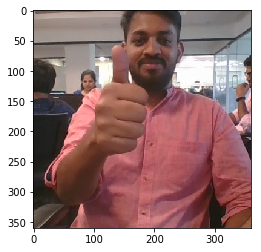

In [10]:
pth = train_path + '/' + train_doc[452].split(';')[0]
imgs = os.listdir(pth)
img = imread(pth + '/' + imgs[1])
plt.imshow(img)

In [11]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(40)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

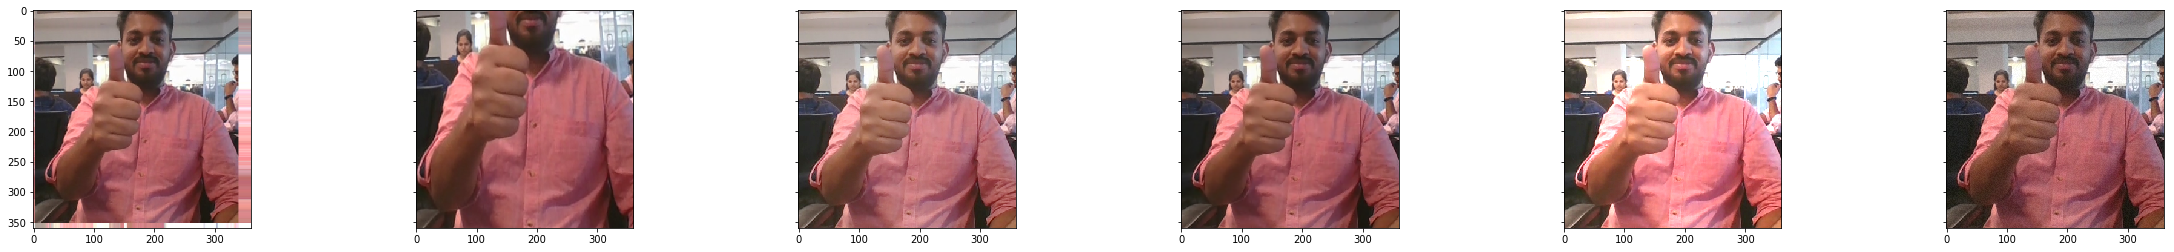

In [12]:
trans = []
for aug in augmenters:
    trans.append(aug.augment_image(img))
plot_image(trans)

Now Let's try to do this and create a new folder for entire sequence of 30 images

In [13]:
import random as rand
import cv2 as cv

### Image augmentation to create double the number of images

This code goes over each of the image sequence and randomnly applies one out of 6 augmentations mentioned above to create a augmented sample. Moreover it creates the labelled data for both the original and augmented image sequence. This block should be run **once** only to create the augmented sequences.

In [14]:
tot_seq = len(train_doc)
with open('./Project_data/train_aug.csv','w') as file:
    for idx in range(tot_seq):
        dir_name = train_doc[idx].split(';')[0]
        category = train_doc[idx].split(';')[1]
        label = train_doc[idx].split(';')[2]
        new_dir_name = dir_name + '_aug'
        im_path = train_path + '/' + dir_name
        imgs = os.listdir(im_path)
        os.mkdir(im_path + '_aug')
        for im in imgs:
            temp_img = imread(im_path + '/' + im)
            augmenter = rand.choice(augmenters)
            rand.shuffle(augmenters)
            aug_img = augmenter.augment_image(temp_img)
            cv.imwrite(os.path.join(im_path + '_aug' , im), cv.cvtColor(aug_img,cv.COLOR_RGB2BGR))
        file.write(train_doc[idx])
        file.write(new_dir_name + ';' + category + ';' + label)

In [15]:
train_doc = np.random.permutation(open('./Project_data/train_aug.csv').readlines())

In [16]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)
# Use all images in the sequence
img_idx = range(0,30,1)

# training sequences = 1326
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## CNN + RNN With Transfer Learning

<img src = "http://aryancodify.tech/wp-content/uploads/2018/12/comparison_transfer.png" />

The reason we experimented with Resnet50 and Inception V3 as two choices for transfer learning is that they have better accuracy to number of operations ratio. Moreover the number of trainable parameters in the Inception V3 model is lesser as well as lesser number of training parameters as compared to Resnet50.

<img src="http://aryancodify.tech/wp-content/uploads/2018/12/inceptionAdvantage.png" />

#### Create the model

In [18]:
from keras.models import Model
from keras.layers import GRU, TimeDistributed, Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3
from keras import optimizers
video = Input(shape=(30, im_length , im_width, 3), name='video_input')
cnn = InceptionV3(
    weights="imagenet",
    include_top=False,
    pooling='max'
)
encoded_frame = TimeDistributed(cnn)(video)
encoded_vid = GRU(1024,return_sequences = True,dropout=0.2)(encoded_frame)
encoded_l2 = GRU(256,return_sequences = False,dropout=0.2)(encoded_vid)
dense = Dense(128, activation='relu')(encoded_l2)
outputs = Dense(5, activation='softmax')(dense)
model = Model(inputs=[video],outputs=outputs)

Note that 20 percent of cells are being dropped out from GRU layers in order to improve validation accuracy.

##### Resnet model. Tried but best accuracy obtained with Inception V3 + GRU.

In [19]:
# video = Input(shape=(30, im_length , im_width, 3), name='video_input')
# cnn = ResNet50(
#     weights='imagenet',
#     include_top=False,
#     pooling='max'
# )
# encoded_frame = TimeDistributed(cnn)(video)
# encoded_vid = GRU(1024,return_sequences = False)(encoded_frame)
# outputs = Dense(5, activation='softmax')(encoded_vid)
# model = Model(inputs=[video],outputs=outputs)

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [20]:
optimiser = optimizers.SGD(lr=0.01, clipnorm=0.7)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
video_input (InputLayer)     (None, 30, 300, 300, 3)   0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 2048)          21802784  
_________________________________________________________________
gru_1 (GRU)                  (None, 30, 1024)          9440256   
_________________________________________________________________
gru_2 (GRU)                  (None, 256)               983808    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 32,260,389
Trainable params: 32,225,957
Non-trainable params: 34,432
___________________________________________________________

### Visualize the Model

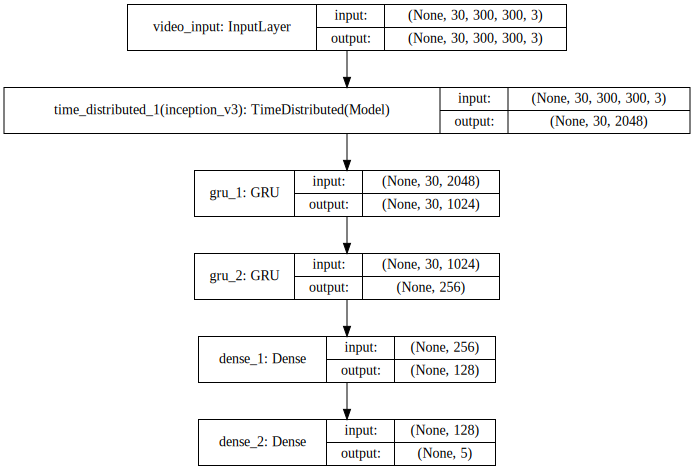

In [21]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

<img src="http://aryancodify.tech/wp-content/uploads/2018/12/model_archi.png" />

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [22]:
train_generator = generator(train_path, train_doc, batch_size, img_idx)
val_generator = generator(val_path, val_doc, batch_size, img_idx)

In [23]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='categorical_accuracy', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='categorical_accuracy', factor=0.2,
                              patience=5, min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [24]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [25]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
Source path =  ./Project_data/train ; batch size = 3
Source path =  ./Project_data/val ; batch size = 3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


441/442 [============================>.] - ETA: 1s - loss: 1.6732 - categorical_accuracy: 0.2041

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


442/442 [==============================] - 668s 2s/step - loss: 1.6736 - categorical_accuracy: 0.2036 - val_loss: 1.5858 - val_categorical_accuracy: 0.2647

Epoch 00001: saving model to model_init_2018-12-3002_37_04.675032/model-00001-1.67361-0.20362-1.58581-0.26471.h5
Epoch 2/20
442/442 [==============================] - 642s 1s/step - loss: 1.6219 - categorical_accuracy: 0.2579 - val_loss: 1.5291 - val_categorical_accuracy: 0.3431

Epoch 00002: saving model to model_init_2018-12-3002_37_04.675032/model-00002-1.62192-0.25792-1.52909-0.34314.h5
Epoch 3/20
442/442 [==============================] - 641s 1s/step - loss: 1.6003 - categorical_accuracy: 0.2655 - val_loss: 1.4339 - val_categorical_accuracy: 0.3922

Epoch 00003: saving model to model_init_2018-12-3002_37_04.675032/model-00003-1.60031-0.26546-1.43394-0.39216.h5
Epoch 4/20
442/442 [==============================] - 640s 1s/step - loss: 1.5302 - categorical_accuracy: 0.3024 - val_loss: 1.3326 - val_categorical_accuracy: 0.4804



## 3-D Convolution Model

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


model = Sequential()

# a keras convolutional layer is called Conv2D
# help(Conv2D)
# note that the first layer needs to be told the input shape explicitly
input_shape = (17, 60, 80, 3)
num_classes = 5
# first conv layer
x = Conv3D(32, kernel_size=(2, 2, 2),
                 activation='relu',
                 input_shape=input_shape) # input shape = (img_rows, img_cols, 1)

model.add(x)
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.1))
# second conv layer
model.add(Conv3D(64, kernel_size=(2, 2, 2),  
                 activation='relu'))
model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.2))

# third conv layer
model.add(Conv3D(128, kernel_size=(2, 2, 2),  
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.1))

# fourth conv layer
model.add(Conv3D(256, kernel_size=(2, 2, 2),  
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.2))

#Fifth
#model.add(Conv3D(256, kernel_size=(2, 2, 2),  
#                 activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#model.add(Dropout(0.3))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(512, activation='relu')) # fully connected

#model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.3))
# softmax layer
model.add(Dense(num_classes, activation='softmax'))


### Viualize the model

In [7]:
optimiser = optimizers.SGD(lr=0.01, clipnorm=0.7)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 59, 79, 32)    800       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 59, 79, 32)    128       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 29, 39, 32)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 29, 39, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 28, 38, 64)     16448     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 28, 38, 64)     256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 28, 38, 64)     0         
__________

### Reinitialise the generator

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50
print ('# epochs =', num_epochs)
# Pick enough frames so that we are able to compile 4 layers of Conv3D and 3 MaxPooling layers
img_idx = [0,2,4,6,8,10,12,14,15,16,17,18,20,22,24,26,28]

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [3]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
#train_doc = train_doc[0:100]
im_length = 60
im_width = 80
batch_size = 2


In [8]:
train_generator = generator(train_path, train_doc, batch_size, img_idx)
val_generator = generator(val_path, val_doc, batch_size, img_idx)

In [11]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
Source path =  ./Project_data/val ; batch size = 2
Source path =  ./Project_data/train ; batch size = 2


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


331/332 [============================>.] - ETA: 0s - loss: 3.4088 - categorical_accuracy: 0.2266

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


332/332 [==============================] - 49s 149ms/step - loss: 3.4121 - categorical_accuracy: 0.2259 - val_loss: 1.8370 - val_categorical_accuracy: 0.3500

Epoch 00001: saving model to model_final_2018-12-2905_00_50.092634/model-00001-3.41049-0.22624-1.83696-0.35000.h5
Epoch 2/50
332/332 [==============================] - 44s 131ms/step - loss: 2.6932 - categorical_accuracy: 0.2816 - val_loss: 1.5874 - val_categorical_accuracy: 0.4100

Epoch 00002: saving model to model_final_2018-12-2905_00_50.092634/model-00002-2.69415-0.28205-1.58741-0.41000.h5
Epoch 3/50
332/332 [==============================] - 45s 136ms/step - loss: 2.4395 - categorical_accuracy: 0.3449 - val_loss: 1.5553 - val_categorical_accuracy: 0.4100

Epoch 00003: saving model to model_final_2018-12-2905_00_50.092634/model-00003-2.44122-0.34540-1.55530-0.41000.h5
Epoch 4/50
332/332 [==============================] - 44s 134ms/step - loss: 1.8160 - categorical_accuracy: 0.4337 - val_loss: 1.3879 - val_categorical_accurac

Epoch 30/50
332/332 [==============================] - 46s 138ms/step - loss: 0.6433 - categorical_accuracy: 0.8102 - val_loss: 0.9299 - val_categorical_accuracy: 0.7300

Epoch 00030: saving model to model_final_2018-12-2905_00_50.092634/model-00030-0.64358-0.80995-0.92987-0.73000.h5
Epoch 31/50
332/332 [==============================] - 46s 138ms/step - loss: 0.5693 - categorical_accuracy: 0.7952 - val_loss: 0.9223 - val_categorical_accuracy: 0.7400

Epoch 00031: saving model to model_final_2018-12-2905_00_50.092634/model-00031-0.57013-0.79487-0.92234-0.74000.h5
Epoch 32/50
332/332 [==============================] - 47s 142ms/step - loss: 0.6451 - categorical_accuracy: 0.7711 - val_loss: 0.9345 - val_categorical_accuracy: 0.7300

Epoch 00032: saving model to model_final_2018-12-2905_00_50.092634/model-00032-0.64600-0.77074-0.93449-0.73000.h5
Epoch 33/50
332/332 [==============================] - 47s 142ms/step - loss: 0.6737 - categorical_accuracy: 0.7621 - val_loss: 0.9225 - val_cate

# Conclusion

When comparing the two models, although 3-D convolution is much lighter model with less number of training parameters its validation accuracy and validation loss are inferior to the **CNN + RNN** model to a large extent which has **~ 90 percent** validation accuracy and **91 percent** training categorical accuracy as well as **0.2** validation and training **loss**. So we chose **CNN + RNN with Inception V3** as our final model.

## (Final Submission) hdf5 CNN + RNN

https://drive.google.com/open?id=1072yTKwswhKzQ7hXbnnip-Ib94MovE85

### (Non Submission) -> 3-D Conv hdf5

https://drive.google.com/open?id=1iSJQMDNLxFzarthS4utYBTTcPRy3N9CT